### 加载数据并处理为tensor形式

训练集大小: 60000
测试集大小: 10000
图像大小: torch.Size([1, 28, 28])


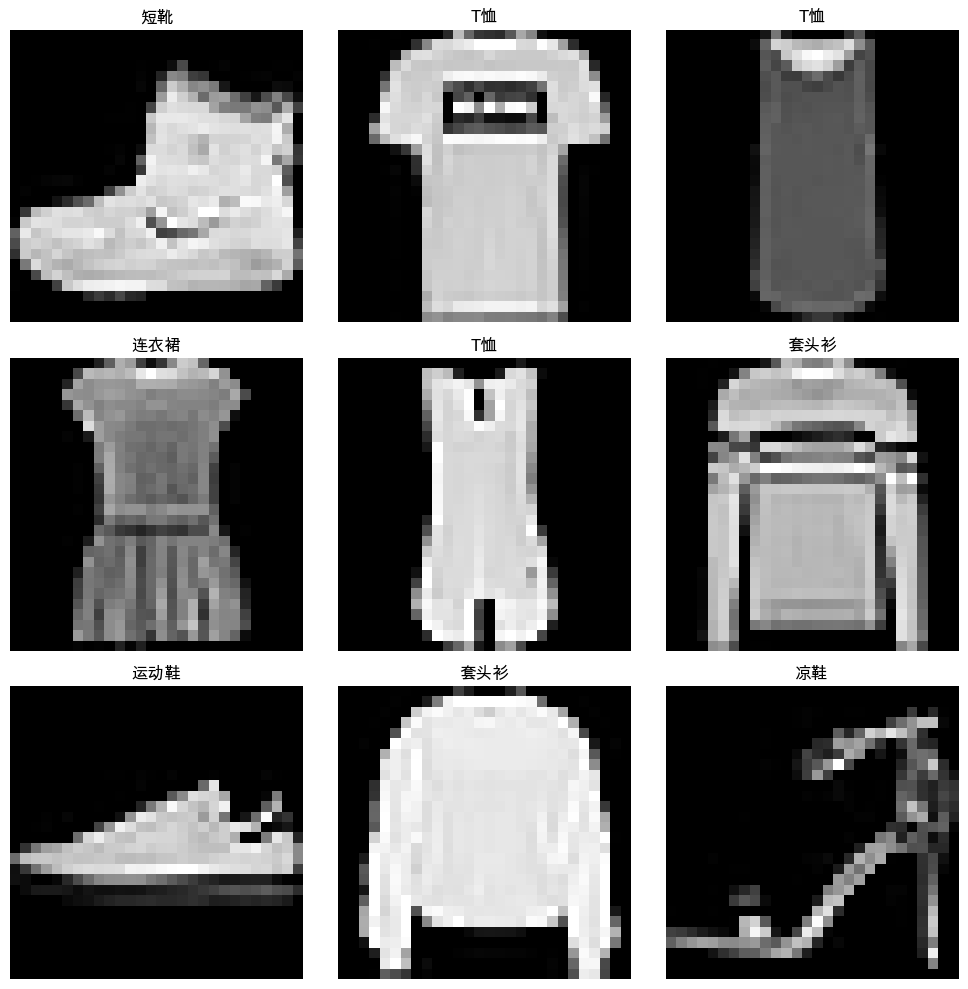


Fashion-MNIST数据集特点:
1. 包含10个类别的时尚物品灰度图像
2. 每张图像大小为28x28像素
3. 训练集60,000张图像，测试集10,000张图像
4. 像素值已归一化到0-1范围


In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from wzh_deeplearning import plot_learning_curves, EarlyStopping, ModelSaver
from wzh_deeplearning import classification_evaluate as evaluate
from wzh_deeplearning import train_classification as train_model
# 定义数据转换
transform = transforms.Compose([
    transforms.ToTensor(),  # 将图像转换为张量并归一化到[0,1]，注意其中做了归一化
    transforms.Normalize((0.286,), (0.353,))
])

# 加载Fashion-MNIST训练集和测试集
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform) #dataset是tensor的集合
test_dataset = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# 定义类别标签
class_names = ['T恤', '裤子', '套头衫', '连衣裙', '外套',
               '凉鞋', '衬衫', '运动鞋', '包', '短靴']

# 显示数据集的基本信息
print(f'训练集大小: {len(train_dataset)}')
print(f'测试集大小: {len(test_dataset)}')
print(f'图像大小: {train_dataset[0][0].shape}')
# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']  # macOS系统使用Arial Unicode MS字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

# 可视化几个样本
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_dataset[i][0].squeeze(), cmap='gray') # squeeze()函数将张量维度为1的维度去掉
    plt.title(class_names[train_dataset[i][1]])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 解释数据集特点
print('\nFashion-MNIST数据集特点:')
print('1. 包含10个类别的时尚物品灰度图像')
print('2. 每张图像大小为28x28像素')
print('3. 训练集60,000张图像，测试集10,000张图像')
print('4. 像素值已归一化到0-1范围')


In [2]:
# 计算训练集的均值和标准差

all_data = torch.stack([img_tensor for img_tensor , _ in train_dataset])
train_mean = torch.mean(all_data)
train_std = torch.std(all_data)

print("训练集均值:", train_mean)
print("训练集标准差:", train_std)


训练集均值: tensor(0.0001)
训练集标准差: tensor(1.0001)


### 划分数据集为训练集和测试集，并加载到DataLoader中，DataLoader会自动将数据进行批量处理，并打乱数据

In [3]:
from torch.utils.data import DataLoader
# 划分训练集和测试集
train_size = 55000
val_size = 5000

# 使用随机采样划分训练集
train_subset, val_subset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# 创建DataLoader
batch_size = 64
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True) #shuffle=True表示训练时打乱数据
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# 输出数据集大小信息
print(f'训练集大小: {len(train_subset)}')
print(f'验证集大小: {len(val_subset)}')
print(f'测试集大小: {len(test_dataset)}')


训练集大小: 55000
验证集大小: 5000
测试集大小: 10000


In [4]:
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, layers_num=2):
        super().__init__()
        self.flatten = nn.Flatten()
        # 多加几层
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
        )
        
        for i in range(1, layers_num):
            self.linear_relu_stack.add_module(f"Linear_{i}", nn.Linear(100, 100))
            self.linear_relu_stack.add_module(f"BatchNorm_{i}", nn.BatchNorm1d(100))#批标准化
            self.linear_relu_stack.add_module(f"relu", nn.ReLU())
        # 输出层
        self.linear_relu_stack.add_module("Output Layer", nn.Linear(100, 10))
        
        # 初始化权重
        self.init_weights()
        
    def init_weights(self):
        """使用 xavier 均匀分布来初始化全连接层的权重 W"""
        # print('''初始化权重''')
        for m in self.modules():
            # print(m)
            # print('-'*50)
            if isinstance(m, nn.Linear):#判断m是否为全连接层
                # https://pytorch.org/docs/stable/nn.init.html
                nn.init.xavier_uniform_(m.weight) # xavier 均匀分布初始化权重
                nn.init.zeros_(m.bias) # 全零初始化偏置项
        # print('''初始化权重完成''')
    def forward(self, x):
        # x.shape [batch size, 1, 28, 28]
        x = self.flatten(x)  
        # 展平后 x.shape [batch size, 28 * 28]
        logits = self.linear_relu_stack(x)
        # logits.shape [batch size, 10]
        return logits


In [5]:
model = NeuralNetwork(layers_num=18)
# 获取训练数据集中的第一个batch
images, labels = next(iter(train_loader))
#print(labels)
# 对第一个batch进行前向计算
outputs = model(images)
#print(outputs)
# 打印输出shape和标签shape
print(f"输出张量形状: {outputs.shape}")
print(f"标签张量形状: {labels.shape}")


输出张量形状: torch.Size([64, 10])
标签张量形状: torch.Size([64])


In [6]:
# 计算模型总参数量
total_params = sum(p.numel() for p in model.parameters())
print(f'模型总参数量: {total_params:,}')

# 打印每层参数量明细
for name, param in model.named_parameters():
    print(f'{name}: {param.numel():,} 参数')


模型总参数量: 441,710
linear_relu_stack.0.weight: 235,200 参数
linear_relu_stack.0.bias: 300 参数
linear_relu_stack.2.weight: 30,000 参数
linear_relu_stack.2.bias: 100 参数
linear_relu_stack.Linear_1.weight: 10,000 参数
linear_relu_stack.Linear_1.bias: 100 参数
linear_relu_stack.BatchNorm_1.weight: 100 参数
linear_relu_stack.BatchNorm_1.bias: 100 参数
linear_relu_stack.Linear_2.weight: 10,000 参数
linear_relu_stack.Linear_2.bias: 100 参数
linear_relu_stack.BatchNorm_2.weight: 100 参数
linear_relu_stack.BatchNorm_2.bias: 100 参数
linear_relu_stack.Linear_3.weight: 10,000 参数
linear_relu_stack.Linear_3.bias: 100 参数
linear_relu_stack.BatchNorm_3.weight: 100 参数
linear_relu_stack.BatchNorm_3.bias: 100 参数
linear_relu_stack.Linear_4.weight: 10,000 参数
linear_relu_stack.Linear_4.bias: 100 参数
linear_relu_stack.BatchNorm_4.weight: 100 参数
linear_relu_stack.BatchNorm_4.bias: 100 参数
linear_relu_stack.Linear_5.weight: 10,000 参数
linear_relu_stack.Linear_5.bias: 100 参数
linear_relu_stack.BatchNorm_5.weight: 100 参数
linear_relu_stack.B

### 设置交叉熵损失函数，和SGD优化器

In [7]:
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()  # 交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam优化器，学习率为0.001，model.parameters()为要优化的参数


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device) 
early_stopping = EarlyStopping(patience=5, delta=0.005)
model_save = ModelSaver(model,save_dir='./model/')
model , history = train_model(model, train_loader,val_loader,criterion, optimizer, device,num_epochs=20,model_saver=model_save,early_stopping=early_stopping)

  0%|          | 0/17200 [00:00<?, ?it/s]

EarlyStopping: val_acc did not improve
早停: 已有5轮验证损失没有改善！


In [9]:
history['val'][-1000:-1] # 取最后1000个数据

[{'loss': 2.0320961912976037, 'acc': 31.54, 'step': 0},
 {'loss': 0.4676506843747972, 'acc': 82.14, 'step': 500},
 {'loss': 0.41936402324634264, 'acc': 84.86, 'step': 1000},
 {'loss': 0.38246806776976283, 'acc': 87.34, 'step': 1500},
 {'loss': 0.4349318391914609, 'acc': 84.04, 'step': 2000},
 {'loss': 0.3678413316418853, 'acc': 87.1, 'step': 2500},
 {'loss': 0.3583580923231342, 'acc': 87.2, 'step': 3000},
 {'loss': 0.3541436980042276, 'acc': 87.8, 'step': 3500},
 {'loss': 0.3641786507413357, 'acc': 87.36, 'step': 4000},
 {'loss': 0.32811972102786924, 'acc': 88.36, 'step': 4500},
 {'loss': 0.34750830655611015, 'acc': 87.66, 'step': 5000},
 {'loss': 0.3474265342649025, 'acc': 87.28, 'step': 5500},
 {'loss': 0.31732633030867274, 'acc': 88.76, 'step': 6000},
 {'loss': 0.41025007129470004, 'acc': 85.46, 'step': 6500},
 {'loss': 0.3534321947188317, 'acc': 87.56, 'step': 7000},
 {'loss': 0.3318165896248214, 'acc': 88.36, 'step': 7500},
 {'loss': 0.3176246979568578, 'acc': 89.1, 'step': 8000},

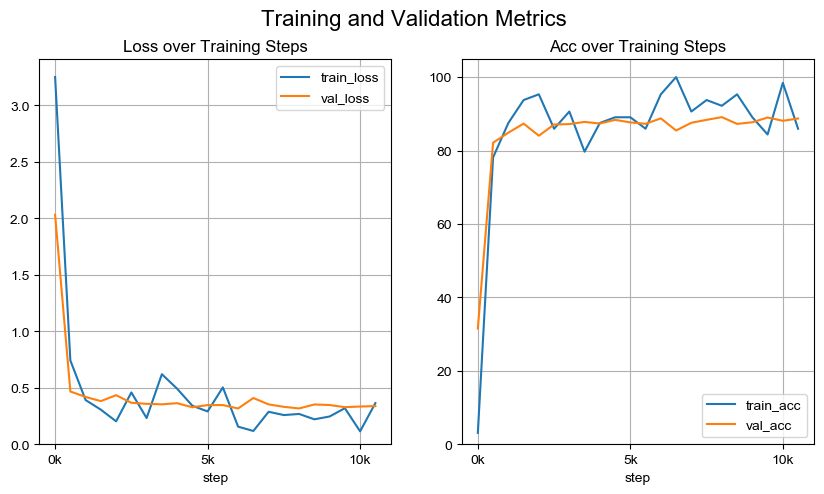

In [10]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [11]:
test_acc = evaluate(model, test_loader,criterion,device)
test_acc

(0.34494842683813376, 88.32)